In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
np.set_printoptions(precision = 2)

import matplotlib.pyplot as plt
%matplotlib inline
(x_train,y_train) , (x_test,y_test) = mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [ ]:
#preprocessing or scaling images pixels

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
#DIMENSIONALITY REDUCTION

#first using PCA-Unsupervised technique as baseline to compared with other deep learning models

x_train_flat = x_train.reshape(len(x_train) , np.prod(x_train.shape[1:]))
x_test_flat = x_test.reshape(len(x_test) , np.prod(x_test.shape[1:]))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [ ]:
from sklearn.decomposition import PCA

def mnist_PCA(x_data,n_components):  #to how dimension it has to be reduced
     pca = PCA( n_components = n_components)

     fit_pca = pca.fit(x_data)

     print("Variance employed with {} components .".format(n_components) , round(sum(fit_pca.explained_variance_ratio_) , 2))

     return fit_pca ,  fit_pca.transform(x_data)



In [ ]:
pca_full , mnist_pca_full = mnist_PCA(x_train_scaled , 784)

Variance employed with 784 components . 1.0


In [ ]:
len(pca_full.explained_variance_ratio_)

784

Text(0, 0.5, 'Proportion of variance explained')

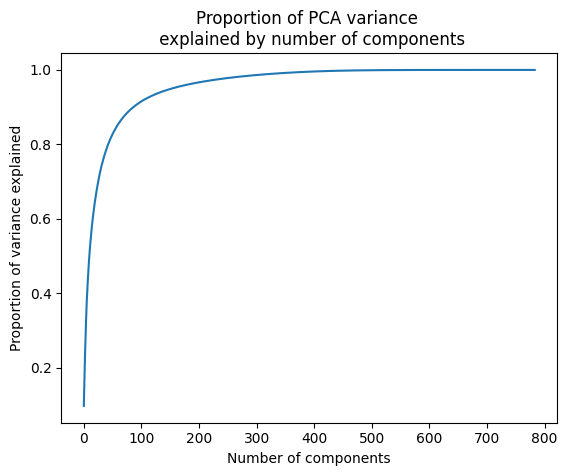

In [ ]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance \n explained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")

In [ ]:
pca_2 , mnist_pca2 = mnist_PCA(x_train_scaled , 2)

Variance employed with 2 components . 0.17


In [ ]:
len(y_train)

60000

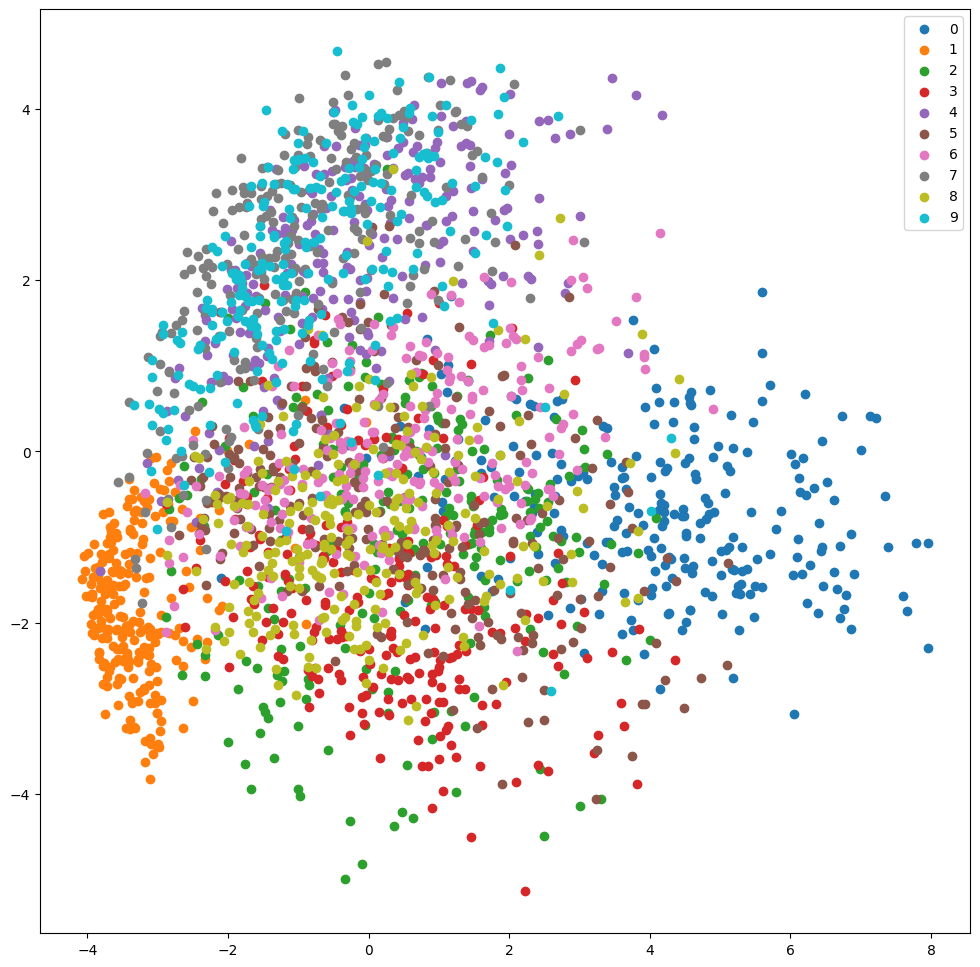

In [ ]:
num_images_per_class = 250
fig = plt.figure(figsize = (12,12))
for number in list(range(10)):
  mask = y_train == number
  x_data = mnist_pca2[mask , 0][:num_images_per_class]
  y_data = mnist_pca2[mask , 1][:num_images_per_class]
  plt.scatter(x_data, y_data , label = number , alpha = 1)
plt.legend()




In [ ]:
pca_64 , mnist_data_64 = mnist_PCA(x_train_scaled , 64)

Variance employed with 64 components . 0.86


In [ ]:
x_test_scaled = s.transform(x_test_flat)

In [ ]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [ ]:
x_test_reconstructed_64.shape

(10000, 784)

In [ ]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [ ]:
def mse_reconstruction(true, reconstructed):
  return np.sum(np.power(true - reconstructed , 2)/true.shape[1])

In [ ]:
mse_reconstruction(true,reconstructed) #this defines the baseline of performance using 64 components for PCA for further models like autoencoder and their variants

90.54685

In [ ]:
#COMPRESSION OF INPUT'S DIMENSION USING SIMPLE AUTOENCODER
#(using functional API instead of sequential building)

from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model

In [ ]:
ENCODING_DIM = 64 #constructing latent space of 64*64 dimension to measure against prescribed baseline

#Encoder Model
input = Input(shape = (784,))  #introduce a blank tensor
encoded = Dense(ENCODING_DIM , activation = "sigmoid")(input)
encoder_model = Model(input,encoded , name = "encoder")

#Decoder Model
encoded_inputs = Input(shape = (ENCODING_DIM , ) , name = 'encoding')
reconstruction = Dense(784 , activation = 'sigmoid')(encoded_inputs)
decoder_model = Model(encoded_inputs , reconstruction , name = 'decoder')

#Defining full model as the combination of the two

outputs = decoder_model(encoder_model(input))
full_model = Model(input , outputs , name = 'full_ae')



In [ ]:
full_model = Model(inputs = input ,
                   outputs = outputs)

full_model.compile(optimizer = 'rmsprop' ,
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
len(x_train_flat)

60000

In [ ]:
history = full_model.fit(x_train_flat,x_train_flat ,shuffle = True , epochs = 1 , batch_size =batch_size)

469/469 [==============================] - 4s 8ms/step - loss: 0.1563 - accuracy: 0.0110


In [ ]:
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                50240     
                                                                 
 decoder (Functional)        (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 [==============================] - 0s 1ms/step


(10000, 64)

In [ ]:
encoded_images[0]

array([0.99, 0.51, 0.8 , 0.99, 1.  , 0.98, 0.01, 0.66, 0.01, 0.99, 0.16,
       0.2 , 0.95, 0.59, 0.48, 1.  , 0.99, 1.  , 1.  , 0.  , 0.99, 0.94,
       0.98, 1.  , 0.91, 0.99, 1.  , 0.76, 1.  , 0.  , 0.38, 0.7 , 0.07,
       0.99, 0.98, 0.62, 0.98, 0.91, 1.  , 0.95, 0.01, 1.  , 0.83, 0.41,
       0.01, 1.  , 0.  , 0.99, 0.3 , 0.99, 0.03, 1.  , 0.99, 0.  , 0.83,
       0.  , 0.29, 0.94, 0.97, 0.89, 0.93, 0.95, 1.  , 0.82],
      dtype=float32)

In [ ]:
# GENERATE RECONSTRUCTED IMAGE

deconstructed_images = full_model.predict(x_test_flat)
mse_reconstruction(deconstructed_images , x_test_flat)

313/313 [==============================] - 1s 2ms/step


287.06717

In [ ]:
# the mse performance is quite worse as compared to baseline so we
# implement more deeper model with large no. of hidden layers with more epochs iterations

ENCODING_DIM = 64
HIDDEN_DIM = 256

#ENCODER MODEL
inputs = Input(shape=(784,))
encoder_hidden = Dense(HIDDEN_DIM , activation = 'relu')(inputs)
encoded = Dense(ENCODING_DIM , activation = "sigmoid")(encoder_hidden)
encoder_model = Model(inputs, encoded , name = 'encoder')

#DECODER MODEL
encoded_inputs = Input(shape = (ENCODING_DIM ,), name = 'encoding')
decoder_hidden = Dense(HIDDEN_DIM , activation = 'relu')(encoded_inputs)
reconstruction = Dense(784, activation = 'sigmoid')(decoder_hidden)
decoder_model = Model(encoded_inputs , reconstruction , name = 'decoder')

#FULL MODEL OF COMBINATION OF THESE TWO MODEL
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs , outputs, name = 'full_se')


In [ ]:
full_model.summary()

Model: "full_se"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                217408    
                                                                 
 decoder (Functional)        (None, 784)               218128    
                                                                 
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_model = Model(inputs = inputs,
                   outputs = outputs)

full_model.compile(optimizer = 'rmsprop',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
history = full_model.fit(x_train_flat, x_train_flat , shuffle = True , epochs = 5, batch_size =32)

Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2271 - accuracy: 0.0100
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1648 - accuracy: 0.0106
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1394 - accuracy: 0.0106
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1263 - accuracy: 0.0109
Epoch 5/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1173 - accuracy: 0.0114


In [ ]:
# GENERATING RECONSTRUCTED IMAGES

decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images , x_test_flat)

313/313 [==============================] - 1s 2ms/step


162.4367

In [ ]:
#This model gives better performance than earlier model but we can
#further tune this performance by increasing the epochs.

def train_ae_epochs(num_epochs):
  ENCODING_DIM = 64
  HIDDEN_DIM = 256

  #ENCODER MODEL
  inputs = Input(shape=(784,))
  encoder_hidden = Dense(HIDDEN_DIM , activation = 'relu')(inputs)
  encoded = Dense(ENCODING_DIM , activation = "sigmoid")(encoder_hidden)
  encoder_model = Model(inputs, encoded , name = 'encoder')

  #DECODER MODEL
  encoded_inputs = Input(shape = (ENCODING_DIM ,), name = 'encoding')
  decoder_hidden = Dense(HIDDEN_DIM , activation = 'relu')(encoded_inputs)
  reconstruction = Dense(784, activation = 'sigmoid')(decoder_hidden)
  decoder_model = Model(encoded_inputs , reconstruction , name = 'decoder')

  #FULL MODEL OF COMBINATION OF THESE TWO MODEL
  outputs = decoder_model(encoder_model(inputs))
  full_model = Model(inputs , outputs, name = 'full_se')

  full_model = Model(inputs = inputs,
                   outputs = outputs)

  full_model.compile(optimizer = 'rmsprop',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

  mse_res = []
  for i in range(num_epochs):
    history = full_model.fit(x_train_flat, x_train_flat , shuffle = True , epochs = 5, batch_size =32)

    decoded_images = full_model.predict(x_test_flat)
    reconstruction_loss = mse_reconstruction(decoded_images , x_test_flat)
    mse_res.append(reconstruction_loss)
    print('Reconstruction loss after epoch {0} is {1}'.
          format(i+1 , reconstruction_loss))

    return mse_res


In [ ]:
train_ae_epochs(10)

Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2283 - accuracy: 0.0098
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1675 - accuracy: 0.0099
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1412 - accuracy: 0.0102
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1285 - accuracy: 0.0091
Epoch 5/5
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 1 is 168.56028747558594


[168.56029]

In [ ]:
# lets model this with variational autoencoders

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import tensorflow as tf


In [ ]:
def sampling(args):

  mu, log_sigma = args
  episilon = K.random_normal(shape = tf.shape(mu)) # creating white noise vector
  sigma = K.exp(log_sigma)
  return mu + sigma*episilon

In [ ]:
hidden_dims = 256
batch_size = 128
latent_dim = 2

epochs = 2

#ENCODER LAYER
inputs = Input(shape = (784,), name = "encoder_input")
x = Dense(hidden_dims , activation = 'relu' )(inputs)

z_mean = Dense(latent_dim , name = 'z_mean')(x)
z_log_var = Dense(latent_dim , name = 'z_log_var')(x)

z = Lambda(sampling , name = 'z')([z_mean, z_log_var])
encoder_model = Model(inputs , [z_mean , z_log_var , z] , name = 'encoder')

In [ ]:
#DECODER MODEL

latent_inputs = Input(shape = (latent_dim,),)
x = Dense(hidden_dims , activation = 'relu')(latent_inputs)
outputs = Dense(784 , activation = 'sigmoid')(x)
decoder_model = Model(latent_inputs, outputs, name = 'decoder')

#INSTANTIATE VAE MODEL

outputs = decoder_model(encoder_model(inputs)[2]) # here 2 refers to third item 'z' in encoder model which pass tuple of mean and std of ditribution as output
vae_model = Model(inputs , outputs , name = 'vae_mlp')

In [ ]:
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#ARCHITECTURE STRUCTURE IN DETAIL

for i,layer in enumerate(vae_model.layers):
  print('Layer', i+1)
  print('Name' , layer.name)
  print('Input Shape' , layer.input_shape )
  print('Output Shape' , layer.output_shape )
  if not layer.weights:
    print("No weights for this layer")
    continue
  for i, weight in enumerate(layer.weights):
    print("Weights" , i+1)
    print("Name" , weight.name)
    print("Weight shape" , weight.shape.as_list())


Layer 1
Name encoder_input
Input Shape [(None, 784)]
Output Shape [(None, 784)]
No weights for this layer
Layer 2
Name encoder
Input Shape (None, 784)
Output Shape [(None, 2), (None, 2), (None, 2)]
Weights 1
Name dense_33/kernel:0
Weight shape [784, 256]
Weights 2
Name dense_33/bias:0
Weight shape [256]
Weights 3
Name z_mean/kernel:0
Weight shape [256, 2]
Weights 4
Name z_mean/bias:0
Weight shape [2]
Weights 5
Name z_log_var/kernel:0
Weight shape [256, 2]
Weights 6
Name z_log_var/bias:0
Weight shape [2]
Layer 3
Name decoder
Input Shape (None, 2)
Output Shape (None, 784)
Weights 1
Name dense_34/kernel:0
Weight shape [2, 256]
Weights 2
Name dense_34/bias:0
Weight shape [256]
Weights 3
Name dense_35/kernel:0
Weight shape [256, 784]
Weights 4
Name dense_35/bias:0
Weight shape [784]


In [ ]:
#EVALUATING PERFORMANCE AND METRICS

reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_mean_12')>

In [ ]:
# using KL Divergence loss

kl_loss = 0.5*(K.exp(z_log_var) - (1+z_log_var) + K.square(z_mean))
kl_loss = K.sum(kl_loss , axis = -1)
total_vae_loss = K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae_model.add_loss(total_vae_loss)

vae_model.compile(optimizer = 'rmsprop',
                  metrics = ['accuracy'])

vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                            

In [ ]:
vae_model.fit(x_train_flat,x_train_flat,epochs = epochs ,batch_size = batch_size)

Epoch 1/2
469/469 [==============================] - 8s 15ms/step - loss: 0.4006 - accuracy: 0.0117
Epoch 2/2
469/469 [==============================] - 8s 18ms/step - loss: 0.2652 - accuracy: 0.0135


In [ ]:
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images,x_test_flat)

313/313 [==============================] - 1s 4ms/step


675.3584

In [ ]:
#Though performance is worse but this model is designed to increase
#interpretability of model of latent space and
# not to minimise the reconstruction error.

#plotting the latent space

models = encoder_model , decoder_model
data = x_test_flat , y_test


In [ ]:
def plot_results_var(models , data,batch_size = 128,model_name = 'vae_mnist' , lim =4):

  encoder ,decoder = models
  x_test, y_test = data
  os.makedirs(model_name ,exist_ok = True)

  filename = os.path.join(model_name , "vae_mean.png")

  #displaying 2D plot of the digit classes in the latent space
  z_mean , z_log_var , z = encoder.predict(x_test , batch_size = batch_size)

  print(z)
  plt.figure(figsize = (12,10))
  plt.scatter(z[:,0] ,z[:,1] ,c = y_test)
  plt.colourbar()
  plt.xlabel('z[0]')
  plt.ylabel('z[1]')
  plt.savefig(filename)
  plt.show()


  filename = os.path.join(model_name, "digits_over_latent.png")
  # display a 10x10 2D manifold of digits
  n = 10
  digit_size = 28
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-1.0 * lim, lim, n)
  grid_y = np.linspace(-1.0 * lim, lim, n)[::-1]

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample, verbose=0)
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(8, 8))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size+1)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap='Greys_r')
  plt.savefig(filename)
  plt.show()

In [ ]:
loss_ae = train_ae_epochs(10)

Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2329 - accuracy: 0.0117
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1691 - accuracy: 0.0097
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1443 - accuracy: 0.0106
Epoch 4/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1300 - accuracy: 0.0111
Epoch 5/5
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 1 is 169.77903747558594
